# Autoencoder

Anomaly detection with autoencoder for the mnist dataset

In [88]:
import time
from collections import defaultdict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
# utility functions
def imshow(img) -> None:
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def count_parameters(model) -> int:
    """
    Returns number of trainable parameters in pt model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [67]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [35]:
# training hyperparameters
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

In [56]:
# load dataset and dataloader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5),
     transforms.Lambda(torch.flatten)])

trainset = torchvision.datasets.MNIST(root='./.data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./.data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

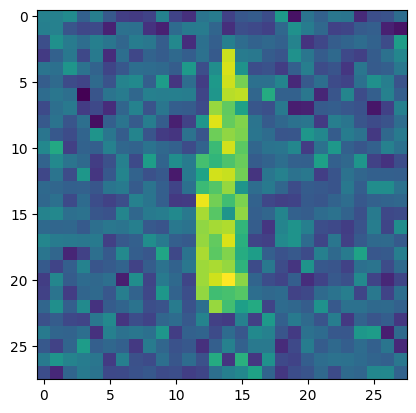

In [78]:
# display data
imshow(gaussian(next(iter(trainloader))[0][0]).view(1, 28, 28))

In [38]:
# define autoencoder model
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [42]:
ae_model = AutoEncoder()
print(f"AE model has {count_parameters(ae_model)} trainable parameters")

AE model has 1154784 trainable parameters


In [44]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(ae_model.parameters(), lr=lr, weight_decay=w_d)

In [46]:
ae_model.to(device)

AutoEncoder(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=784, bias=True)
    (11): ReLU()
  )
)

In [64]:
ae_model.train()
start = time.perf_counter()

for epoch in range(epochs):
    ep_start = time.perf_counter()
    running_loss = 0.0
    for bx, (X, _) in enumerate(trainloader):
        X = X.to(device)
        optimizer.zero_grad()  # zero the parameter gradients

        # forward + backward + optimize
        X_reconstructed = ae_model(X)
        loss = criterion(X, X_reconstructed)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(trainset)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.perf_counter()

    print("-----------------------------------------------")
    print(f"Epoch {epoch+1}/{epochs}. Loss: {epoch_loss}")
    print(f"Epoch {epoch+1} took {ep_end - ep_start:.2f}s ")
end = time.perf_counter()
print("-----------------------------------------------")
print(f"Training Complete: {end-start:.2f}")

-----------------------------------------------
Epoch 1/15. Loss: 0.028925935312112173
Epoch 1 took 6.64s 
-----------------------------------------------
Epoch 2/15. Loss: 0.028920156168937682
Epoch 2 took 6.62s 
-----------------------------------------------
Epoch 3/15. Loss: 0.028918656623363494
Epoch 3 took 6.50s 
-----------------------------------------------
Epoch 4/15. Loss: 0.028917983603477478
Epoch 4 took 6.95s 
-----------------------------------------------
Epoch 5/15. Loss: 0.028917611450950304
Epoch 5 took 6.77s 
-----------------------------------------------
Epoch 6/15. Loss: 0.028917399896184602
Epoch 6 took 6.55s 
-----------------------------------------------
Epoch 7/15. Loss: 0.028917270677288373
Epoch 7 took 6.41s 
-----------------------------------------------
Epoch 8/15. Loss: 0.028917179305354753
Epoch 8 took 6.69s 
-----------------------------------------------
Epoch 9/15. Loss: 0.028917108259598413
Epoch 9 took 6.58s 
-------------------------------------

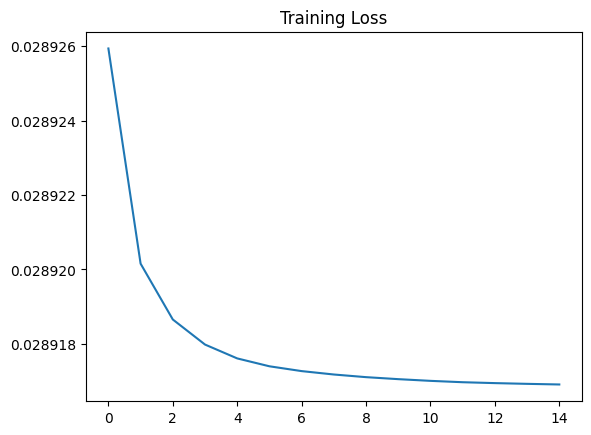

In [66]:
plt.title("Training Loss")
plt.plot(metrics['train_loss'])
plt.show()

In [81]:
# test on data with added noise
gaussian = AddGaussianNoise(0., 0.4)
ae_model.eval()

loss_dist = []
label_ids = []  # 1 is anomaly, 0 is normal

# shuffle should be set to false for testing data
for bx, (X, _) in enumerate(testloader):
    if np.random.rand() < 0.4:
        X = gaussian(X)
        label_ids.append(1)
    else:
        label_ids.append(0)
    X = X.to(device)
    X_reconstructed = ae_model(X)
    loss = criterion(X, X_reconstructed)
    loss_dist.append(loss.item())

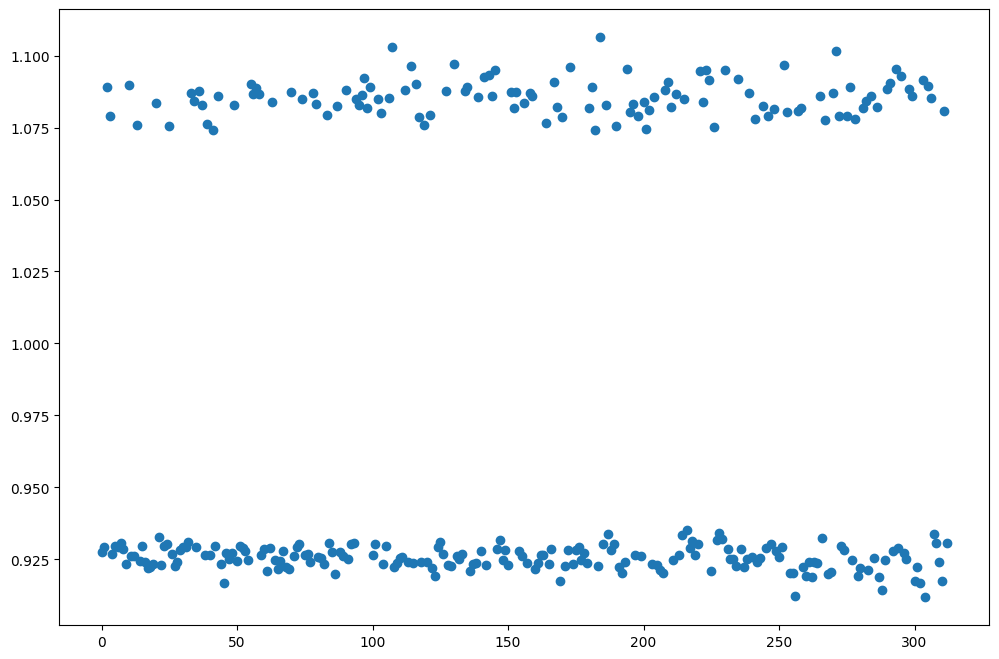

In [87]:
plt.figure(figsize=(12, 8))

plt.scatter(range(len(loss_dist)), loss_dist)
plt.show()

/Users/samridhashrestha/Downloads/books/ml_algo_implementations/ml_autoencoder/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samridhashrestha/Downloads/books/ml_algo_implementations/ml_autoencoder/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/samridhashrestha/Downloads/books/ml_algo_implementations/ml_autoencoder/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x600 with 0 Axes>

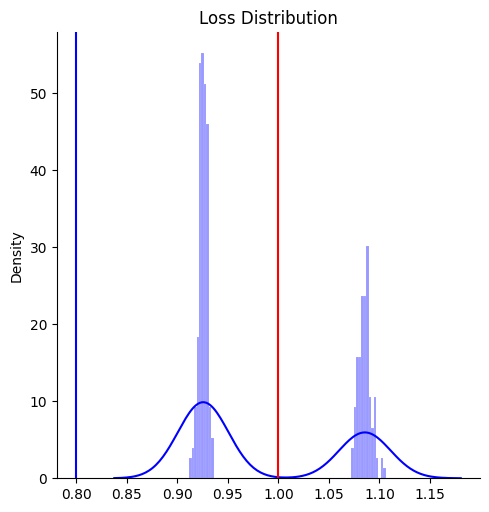

In [103]:
lower_threshold = 0.8
upper_threshold = 1.0
plt.figure(figsize=(12,6))
sns.displot(loss_dist, bins=80, kde=True, stat="density", 
            color='blue', kde_kws=dict(cut=3),
            alpha=.4, edgecolor=(1, 1, 1, .4),)
plt.title('Loss Distribution')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')
plt.show()

In [104]:
# evaluate anomaly classifier that uses the reconstruction loss and a threshold from our observations
thres = 1.0  # threshold is based on the figure above
pred_label_ids = [0 if loss < thres else 1 for loss in loss_dist]

In [106]:
tp, tn, fp, fn = 0, 0, 0, 0

for pred, target in zip(pred_label_ids, label_ids):
    if pred and target:
        tp += 1
    elif pred and not target:
        fp += 1
    elif not pred and target:
        fn += 1
    elif not pred and not target:
        tn += 1

In [111]:
print(f"Accuracy = {100 * (tp + tn) / (tp + tn + fp + fn)}%")
print(f"Precision = {100 * tp / (tp + fp)}%")
print(f"Recall = {100 * tp / (tp + fn)}%")

Accuracy = 100.0%
Precision = 100.0%
Recall = 100.0%
